In [1]:
import numpy as np
import os
import random
import sys

import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch import nn, Tensor

from functools import partial
from omegaconf import DictConfig
from tqdm.notebook import tqdm
from typing import Any, Callable, Dict, Iterable, List, Tuple

In [24]:
import cv2
import PIL
import kornia

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
BASE_DIR = '/home/dmitry/projects/dfdc'
SRC_DIR = os.path.join(BASE_DIR, 'src')
HDF5_DIR = '/media/dmitry/other/dfdc-crops/hdf5'
IMG_DIR = '/media/dmitry/other/dfdc-crops/webp_lossy'

In [5]:
sys.path.insert(0, SRC_DIR)
sys.path.insert(0, './utils')

In [6]:
from dataset import HDF5Dataset, ImagesDataset, FrameSampler, BalancedSampler, simple_transforms
from dataset.transforms import image_grad
from visualise import show_images

In [7]:
from torch.utils.data import DataLoader

In [8]:
sys.path.insert(0, os.path.join(SRC_DIR, 'train.py'))

In [9]:
def create_loader(conf: Dict, transforms: Iterable[Callable],
                  dirs: Iterable[str]) -> DataLoader:
    num_frames = conf['frames']
    
    sampler = FrameSampler(num_frames, 
                           real_fake_ratio=conf['real_fake_ratio'],
                           p_sparse=conf['p_sparse'])
    
    ds = HDF5Dataset(HDF5_DIR,
                     frames=num_frames,
                     sampler=sampler,
                     transforms=transforms,
                     sub_dirs=dirs)
    print("Num samples: {}".format(len(ds)))

    sampler = BalancedSampler(ds, 
        num_samples=conf['num_samples'],
        rank=conf['rank'],
        num_replicas=conf['num_replicas'])
    if 'epoch' in conf:
        sampler.set_epoch(conf['epoch'])
    return DataLoader(ds, 
        sampler=sampler, 
        batch_size=conf['batch_size'],
        drop_last=True,
        num_workers=conf.get('loader.workers', 0))

In [10]:
class RandomHorizontalFlipTensor(object):
    def __init__(self, p=0.5):
        if p < 0 or p > 1:
            raise ValueError("range of random erasing probability should be between 0 and 1")
        self.p = p

    def __call__(self, t: Tensor):
        if random.uniform(0, 1) < self.p:
            return t.flip(-1)
        return t

In [46]:
class Resize(object):
    def __init__(self, size: int):
        self.size = size

    def __call__(self, image: np.ndarray):
        size = (self.size, self.size)
        return cv2.resize(image, dsize=size, interpolation=cv2.INTER_AREA)

In [ ]:
kornia.

In [47]:
conf = dict(
    real_fake_ratio=100/30, 
    p_sparse=1.0, 
    img_size=256, 
    frames=10,
    batch_size=16,
    ep=1
)
dirs = ['dfdc_train_part_%d' % i for i in range(50)]

transforms = T.Compose([
    Resize(256),
    T.ToTensor(),
    # RandomHorizontalFlipTensor(p=0.5),
    kornia.augmentation.RandomHorizontalFlip(p=0.0)
#     T.Lambda(partial(image_grad, n=3, keep_size=True)),
#     T.Normalize(
#         mean=[7.99074656e-10, 9.42090607e-10, 6.85161949e-10],
#         std=[0.03253524, 0.03236544, 0.03264875]
#     )
])

In [48]:
conf = dict(
    real_fake_ratio=100/30, 
    p_sparse=1.0, 
    img_size=256, 
    frames=10,
    batch_size=16,
    rank=None,
    num_replicas=None,
    num_samples=200_000,
    epoch=1
)

dl = create_loader(conf, transforms, dirs)

Num samples: 118890


In [49]:
data_iter = iter(dl)

In [50]:
x, y = next(data_iter)

In [15]:
# mean = np.array([0.0] * 3)
# std = np.array([0.0] * 3)

# for i in tqdm(range(len(dl))):
#     x, y = next(data_iter)
#     m, s = x.mean((0, 2, 3, 4)), x.std((0, 2, 3, 4))
#     for c in range(3):
#         mean[c] += m[c].item()
#         std[c] += s[c].item()

In [16]:
# mean/(i+1), std/(i+1)

In [17]:
# x.shape, x.device

In [18]:
# 100, 256px, n=3, cuda - 1:45s
# 100, 256px, n=3, cpu - 1:43s

In [19]:
# images = x.permute(0, 2, 3, 4, 1)[:, 0].cpu().numpy()

In [20]:
# images.clip(min=-1, max=1).min()

In [21]:
# images.max(), images.min()

In [22]:
# images = x.flip(-1).permute(0, 2, 3, 4, 1)[0].cpu().numpy()
# show_images(images, cols=len(images)//4)

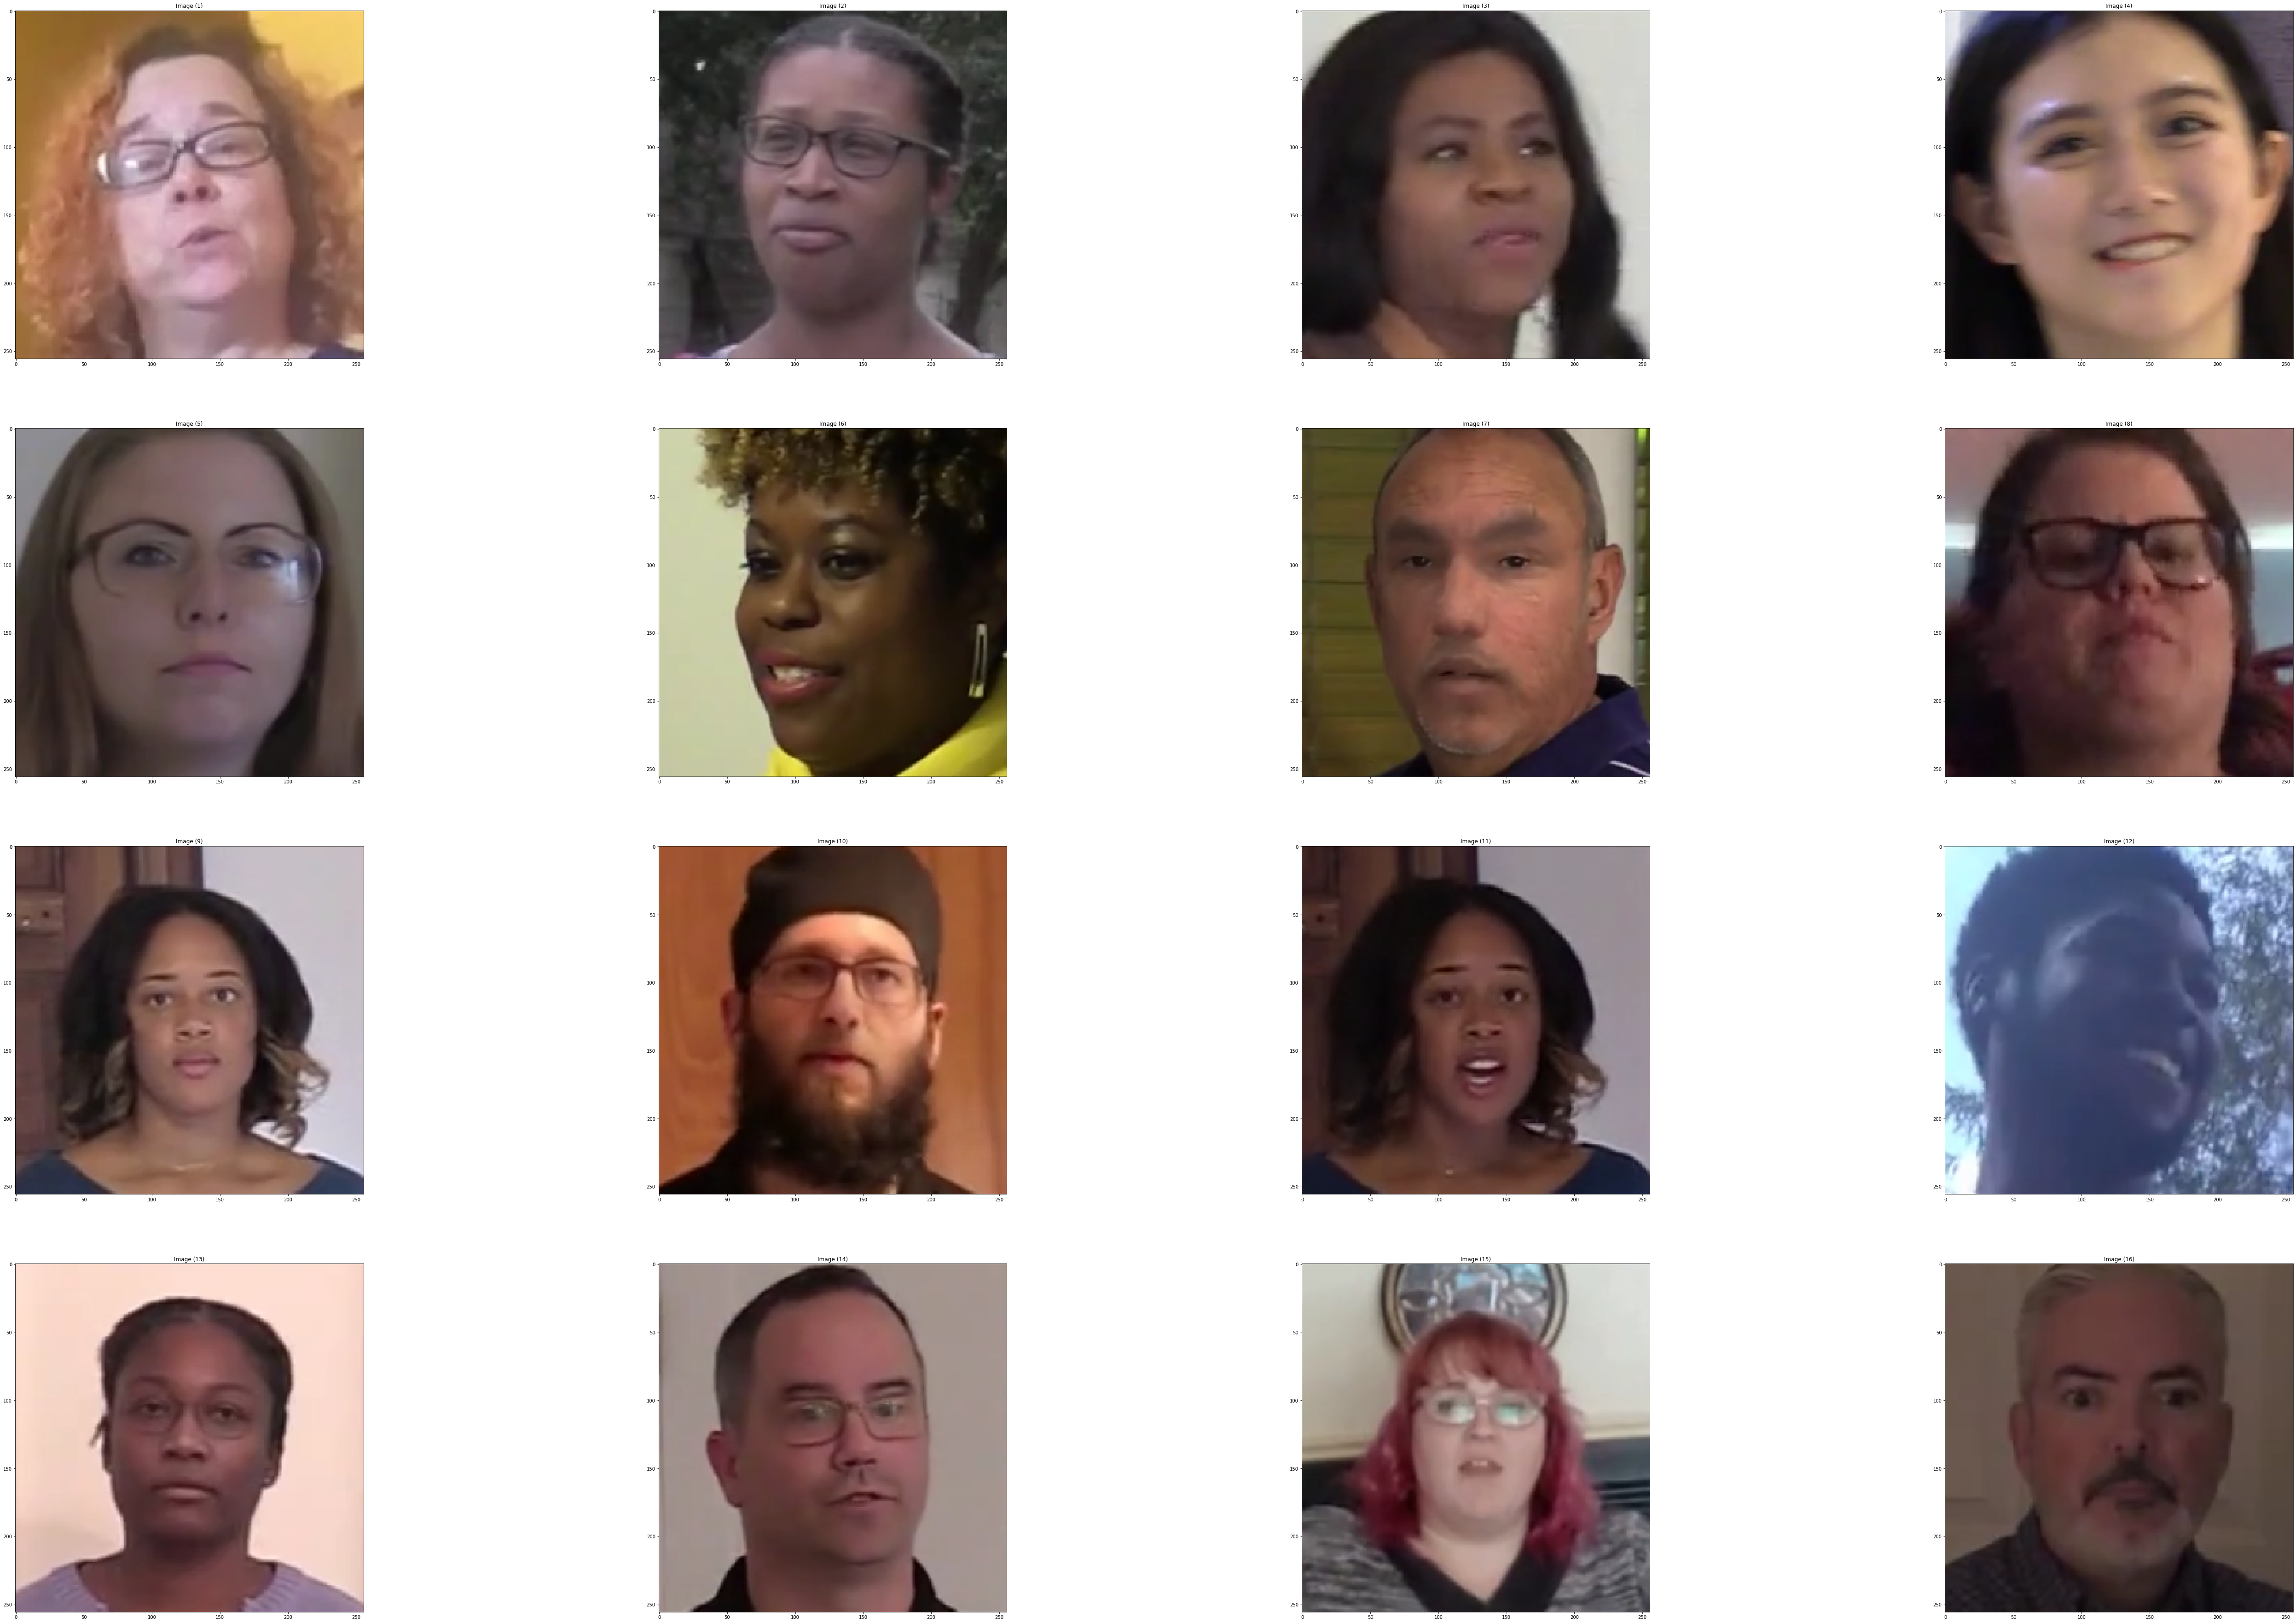

In [38]:
images = x.permute(0, 2, 3, 4, 1)[:, 0].cpu().numpy()
show_images(images, cols=len(images)//4)

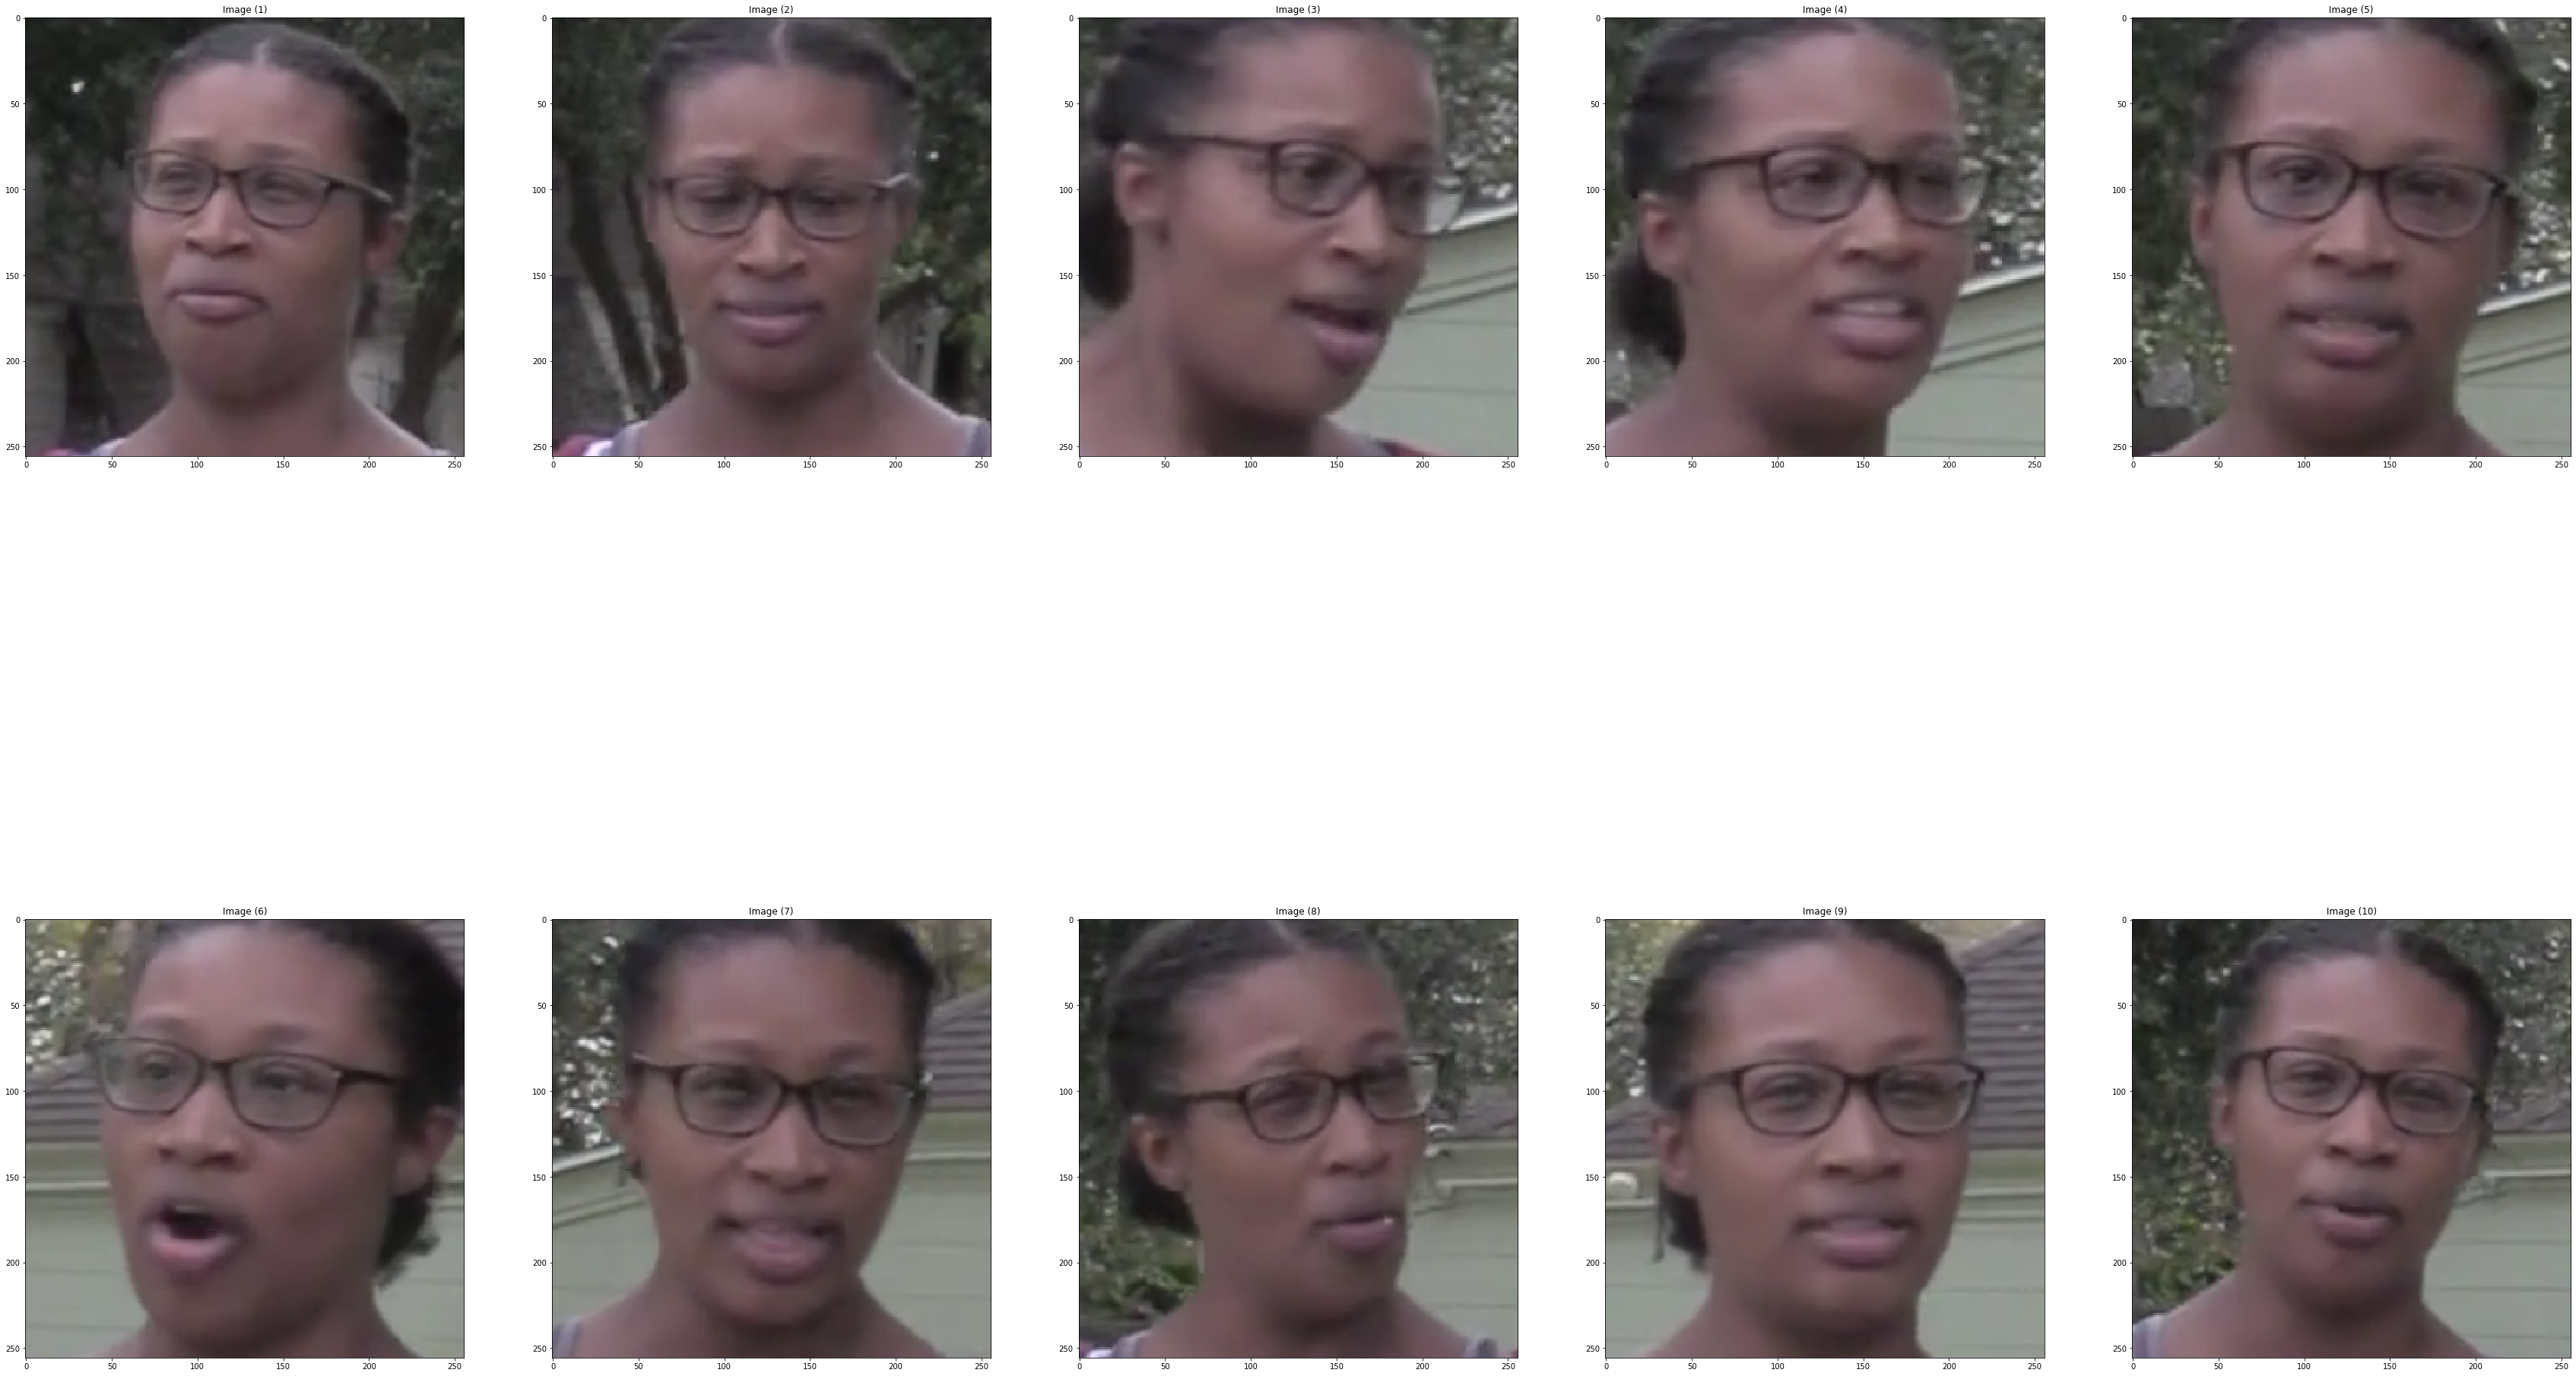

In [39]:
images = x.permute(0, 2, 3, 4, 1)[1].cpu().numpy()
show_images(images, cols=len(images)//4)

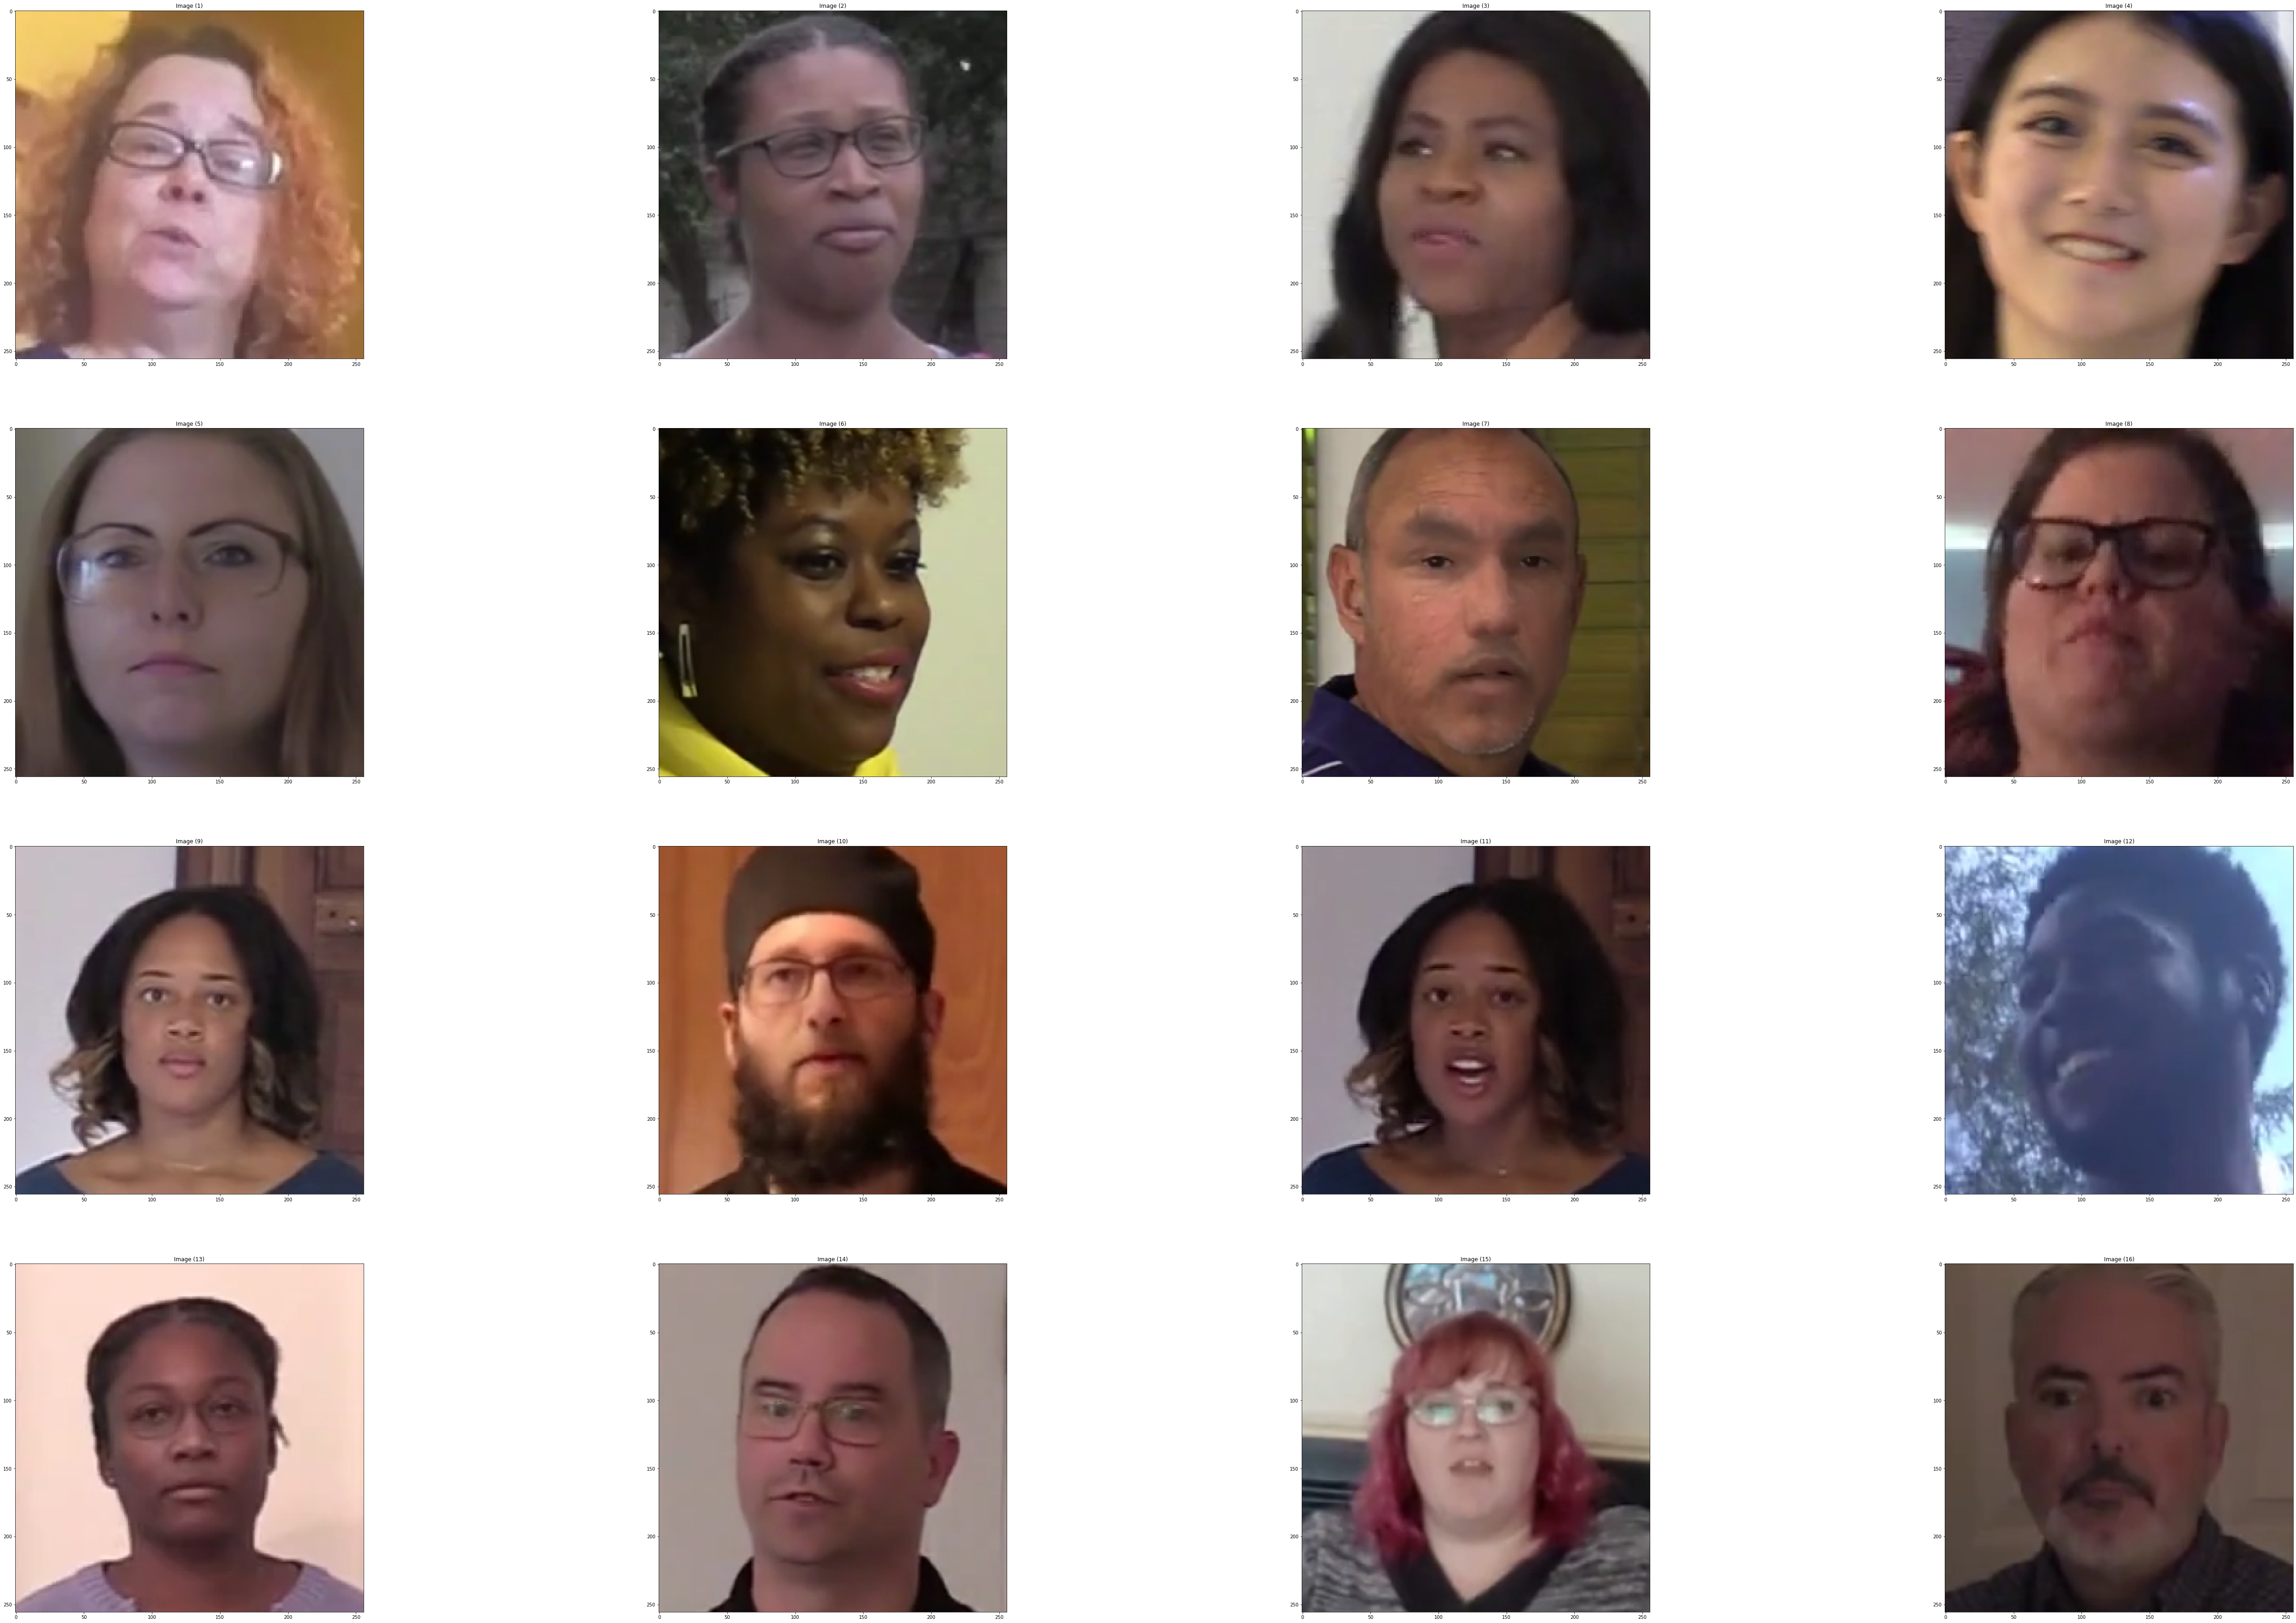

In [51]:
images = x.permute(0, 2, 3, 4, 1)[:, 0].cpu().numpy()
show_images(images, cols=len(images)//4)

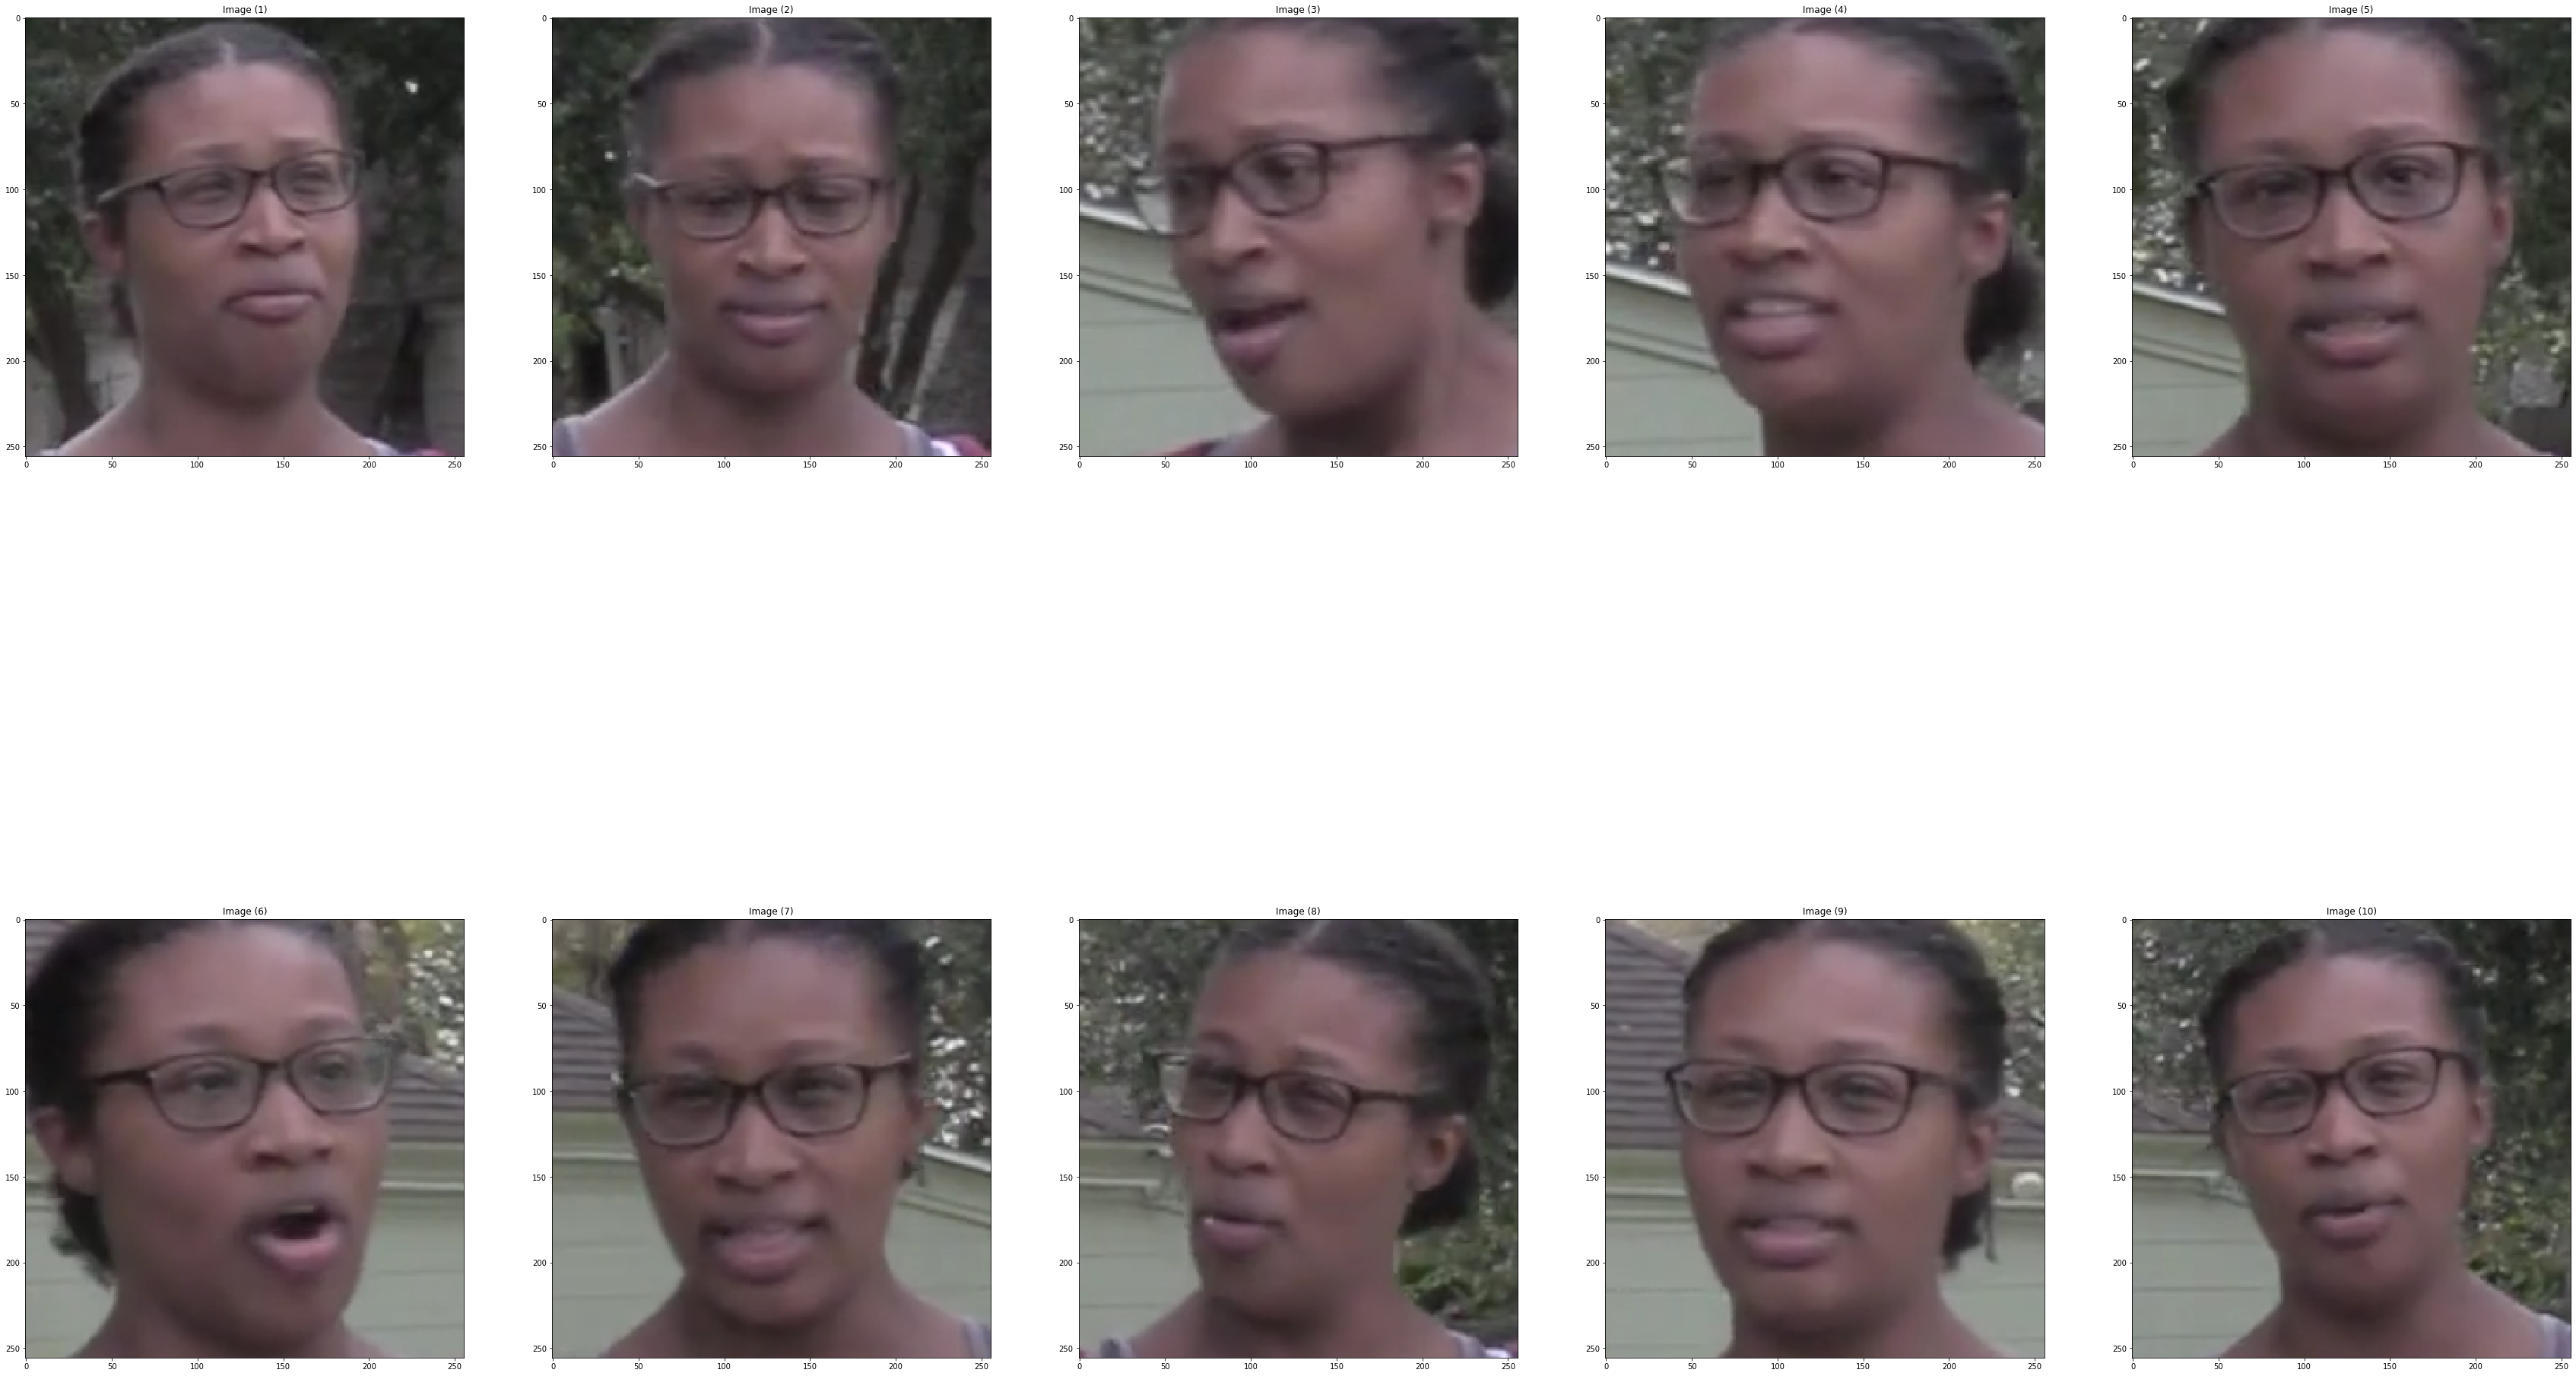

In [52]:
images = x.permute(0, 2, 3, 4, 1)[1].cpu().numpy()
show_images(images, cols=len(images)//4)

In [57]:
from omegaconf import OmegaConf

In [60]:
conf = OmegaConf.load('/home/dmitry/projects/dfdc/config/core.yaml')

In [63]:
conf['data']['train']

{'type': 'hdf5', 'dir': '/media/dmitry/other/dfdc-crops/hdf5', 'chunks': '5 - 50', 'dir_list': '', 'sample': {'frames': 10, 'real_fake_ratio': 3.33, 'sparse_frames_prob': 0.5}, 'loader': {'batch_size': 16, 'workers': 1}}

In [76]:
tfms_conf = OmegaConf.load('/home/dmitry/projects/dfdc/config/data/common.yaml')

In [77]:
for t in tfms_conf['data']['train']['transforms']:
    print(t)

{'transform': {'class': 'dataset.transforms.Resize', 'params': {'size': 256}}}
{'transform': {'class': 'torchvision.transforms.ToTensor'}}
{'transform': {'class': 'dataset.transforms.ImageGrad', 'params': {'order': 3}}}
{'transform': {'class': 'torchvision.transforms.Normalize', 'params': {'mean': [4.09008235e-10, 3.37999846e-10, 4.81442422e-10], 'std': [0.03264627, 0.03247622, 0.03276182]}}}
{'kek': 1, 'lel': 2}
